In [1]:
from rich import print
import pandas as pd
from copy import deepcopy


import wntr
from wntr.network import LinkStatus, WaterNetworkModel
from wntr.network.controls import ControlAction, Control, Comparison
from wntr.sim import EpanetSimulator

In [2]:
wn = WaterNetworkModel("../networks/any-town.inp")
node_name_list = ['90','50','170']
pump_name_list = wn.pump_name_list
tank_name_list = wn.tank_name_list

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt



def sim_create_df(pressures, tank_levels):
    pressures_df = {'node':[], 'time':[], 'pressure':[]}
    for node, pressure in pressures.items():
        if node not in node_name_list:
            continue
        for t, p in pressure.items():
            pressures_df['node'].append(node)
            pressures_df['time'].append(t)
            pressures_df['pressure'].append(p)
    pressures_df = pd.DataFrame(pressures_df)    

    tank_levels_df = {'tank':[], 'time':[], 'level':[]}
    for tank, level in tank_levels.items():
        if tank not in tank_name_list:
            continue
        for t, l in level.items():
            tank_levels_df['tank'].append(tank)
            tank_levels_df['time'].append(t)
            tank_levels_df['level'].append(l)
    tank_levels_df = pd.DataFrame(tank_levels_df)
    return pressures_df, tank_levels_df


def sim_plot(pressures_df, tank_levels_df):
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    fig.suptitle("Pressures and Tank Levels")

    # Plot pressures
    sns.lineplot(data=pressures_df, x='time', y='pressure', hue='node', ax=ax1)
    ax1.set_title('Pressures')
    ax1.set_ylabel('Pressure')

    # Plot tank levels
    sns.lineplot(data=tank_levels_df, x='time', y='level', hue='tank', ax=ax2)
    ax2.set_title('Tank Levels')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Level')

    plt.tight_layout()
    plt.show()


def sim_run(wn: WaterNetworkModel, duration: int, verbose: bool = False):
    wn.options.time.duration = duration
    sim = EpanetSimulator(wn)
    out = sim.run_sim()
    pressures = out.node['pressure'].to_dict()
    tank_levels = out.node['head'].to_dict()
    if not verbose:
        return pressures, tank_levels

    pressures_df, tank_levels_df = sim_create_df(pressures, tank_levels)
    sim_plot(pressures_df, tank_levels_df)


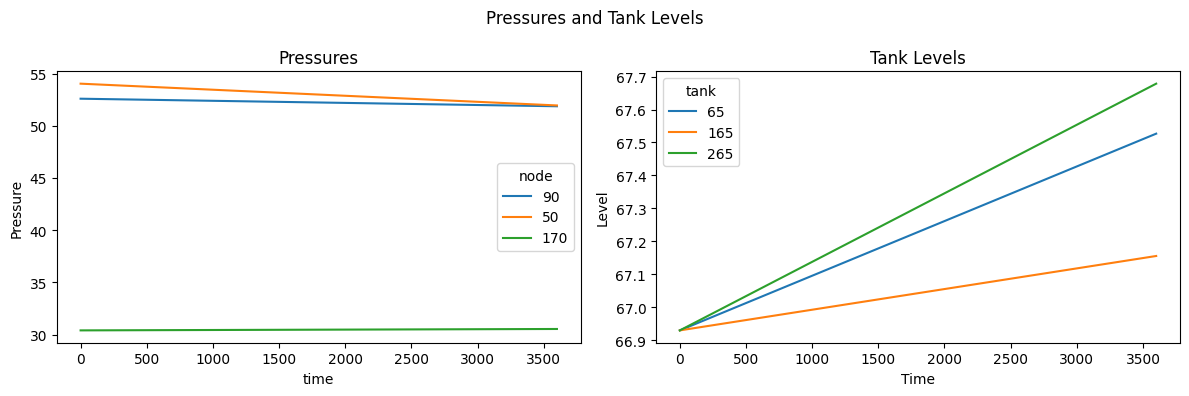

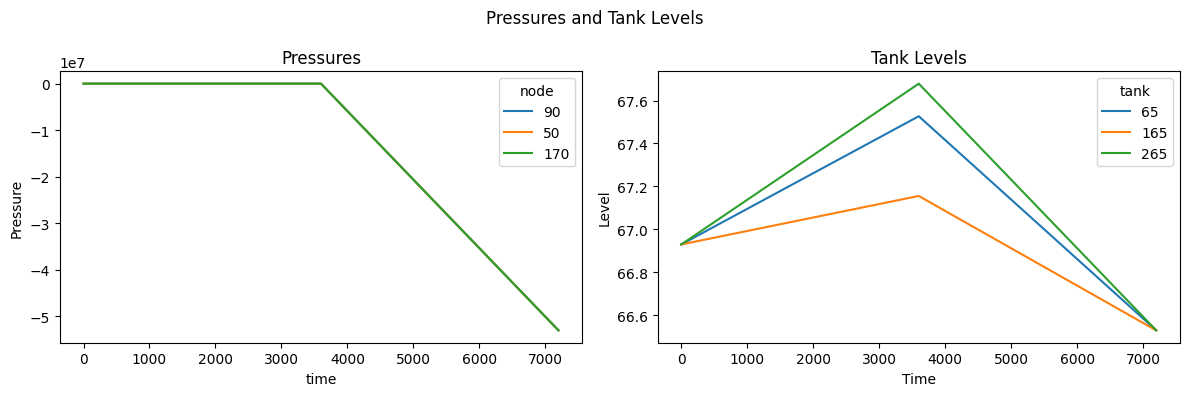

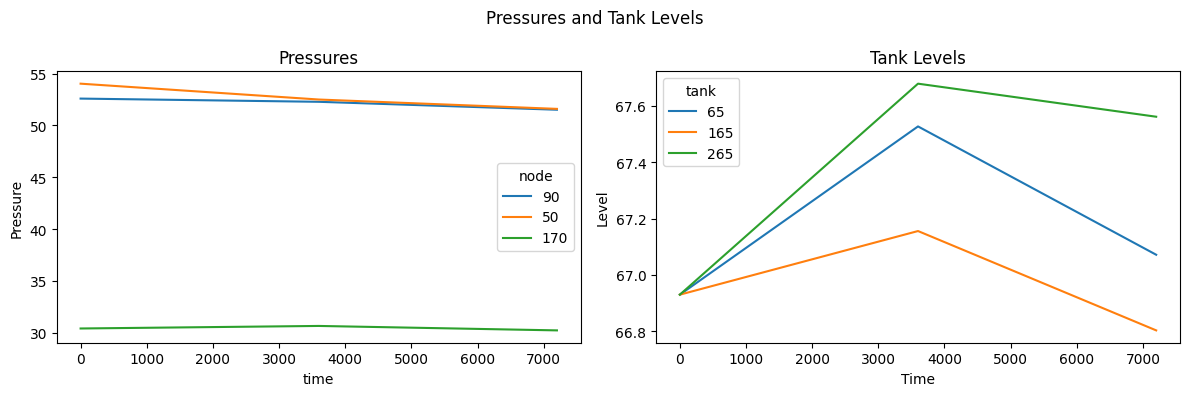

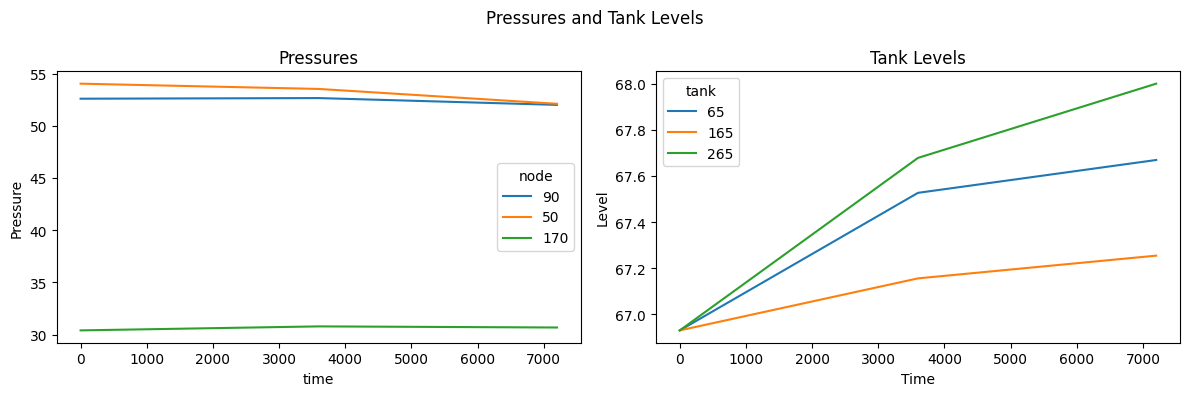

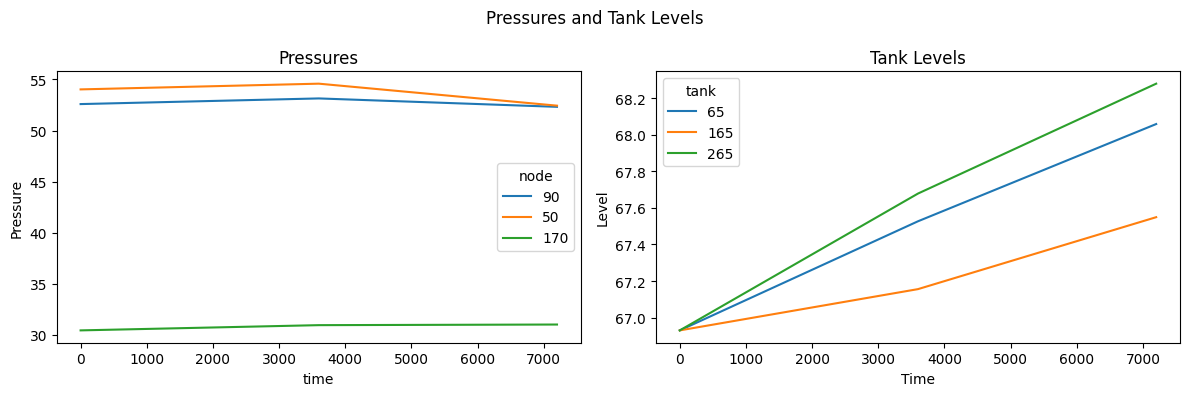

In [9]:
from wntr.network.controls import ControlAction, Control, TimeOfDayCondition, Comparison

def model_add_pump_control(wn: WaterNetworkModel, pump_name: str, status: LinkStatus, time: float) -> str:
    # check if the control already exists
    control_name = f"{time:05d}_{pump_name}_{status}"
    controls = list(wn.controls())
    for name, control in controls:
        if name == control_name:
            print(f"Control {control_name} already exists")
            return
    pump = wn.get_link(pump_name)
    threshold = time
    condition = TimeOfDayCondition(wn, Comparison.eq, threshold)
    action = ControlAction(target_obj=pump, attribute="status", value=status)
    control = Control(condition, then_action=action)
    wn.add_control(control_name, control)
    return control_name

def model_clean_controls(wn: WaterNetworkModel):
    control_name_list = [control_name for control_name, _ in wn.controls()]
    for control_name in control_name_list:
        wn.remove_control(control_name)

model_clean_controls(wn)
control_name_list = []
control_name_list.append(model_add_pump_control(wn, pump_name_list[0], LinkStatus.OPEN, 0))
control_name_list.append(model_add_pump_control(wn, pump_name_list[1], LinkStatus.OPEN, 0))
control_name_list.append(model_add_pump_control(wn, pump_name_list[2], LinkStatus.OPEN, 0))

sim_run(wn, 3600, True)

wn_copy = deepcopy(wn)
sim_run(wn_copy, 7200, True)

wn_copy = deepcopy(wn)
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[0], LinkStatus.OPEN, 3600))
sim_run(wn_copy, 7200, True)

wn_copy = deepcopy(wn)
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[0], LinkStatus.OPEN, 3600))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[1], LinkStatus.OPEN, 3600))
sim_run(wn_copy, 7200, True)

wn_copy = deepcopy(wn)
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[0], LinkStatus.OPEN, 3600))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[1], LinkStatus.OPEN, 3600))
control_name_list.append(model_add_pump_control(wn_copy, pump_name_list[2], LinkStatus.OPEN, 3600))
sim_run(wn_copy, 7200, True)



In [5]:
control_name_list[0]

'00000_222_Open'